# Stock Market Analysis & Prediction using LSTM

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=300449 sha256=4fe4959e2301c4937a7d1cfb4209618669c0e2050bfaf954f8edb6547e22da66
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import mean_squared_error, mean_absolute_error

# fetching financial data from various online sources and returning it as a pandas DataFrame
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

## Load Datasets

In [3]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

In [4]:
end = datetime.now() # current date
start = datetime(end.year - 1, end.month, end.day) # set to exactly one year before the current date

In [5]:
print(end)
print(start)

2024-10-18 14:14:36.304254
2023-10-18 00:00:00


In [6]:
stock_data = {}

for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
stock_data['AAPL']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-18,175.580002,177.580002,175.110001,175.839996,174.944794,54764400
2023-10-19,176.039993,177.839996,175.190002,175.460007,174.566727,59302900
2023-10-20,175.309998,175.419998,172.639999,172.880005,171.999863,64189300
2023-10-23,170.910004,174.009995,169.929993,173.000000,172.119247,55980100
2023-10-24,173.050003,173.669998,171.449997,173.440002,172.557022,43816600
...,...,...,...,...,...,...
2024-10-14,228.699997,231.729996,228.600006,231.300003,231.300003,39882100
2024-10-15,233.610001,237.490005,232.369995,233.850006,233.850006,64751400
2024-10-16,231.600006,232.119995,229.839996,231.779999,231.779999,34082200


In [8]:
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]
name_lst = list(zip(stock_data.keys(), company_name))

name_lst

[('AAPL', 'APPLE'),
 ('GOOG', 'GOOGLE'),
 ('MSFT', 'MICROSOFT'),
 ('AMZN', 'AMAZON')]

In [9]:
for com_name in name_lst:
    stock_data[com_name[0]]['company_name'] = com_name[1]

In [10]:
stock_data['GOOG']

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-10-18,140.750000,141.990005,138.705002,139.279999,138.938782,18304900,GOOGLE
2023-10-19,139.800003,141.005005,138.600006,138.979996,138.639526,21831200,GOOGLE
2023-10-20,138.589996,139.039993,136.244995,136.740005,136.405014,24953900,GOOGLE
2023-10-23,136.229996,139.020004,135.110001,137.899994,137.562164,20780700,GOOGLE
2023-10-24,139.160004,140.710007,138.750000,140.119995,139.776733,26535200,GOOGLE
...,...,...,...,...,...,...,...
2024-10-14,164.910004,167.619995,164.779999,166.350006,166.350006,9981800,GOOGLE
2024-10-15,167.139999,169.089996,166.050003,166.899994,166.899994,14829300,GOOGLE
2024-10-16,166.029999,167.279999,165.216003,166.740005,166.740005,9968500,GOOGLE


## Exploratory Data Analysis (EDA)

- #### Descriptive Statistics about the Data

.describe() generates descriptive statistics

In [11]:
stock_data['AAPL'].describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,196.858814,198.630751,195.173241,197.009783,196.607077,5.864873e+07
std,21.004890,21.216559,20.591588,20.969617,21.165323,3.013527e+07
min,165.350006,166.399994,164.080002,165.000000,164.585999,1.563533e+07
25%,181.789993,182.889999,180.130005,181.710007,181.104446,4.349080e+07
50%,190.979996,192.199997,189.740005,191.289993,190.726257,5.239360e+07
75%,218.929993,221.270004,216.710007,218.800003,218.547043,6.488540e+07
max,236.479996,237.490005,234.020004,235.205002,235.205002,3.186799e+08


In [12]:
stock_data['GOOG'].describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,156.325479,157.874233,154.908589,156.379486,156.092106,2.026430e+07
std,16.997083,17.131785,16.860775,16.954982,16.984812,8.466182e+06
min,124.029999,124.440002,121.459999,123.400002,123.097694,3.853496e+06
25%,140.750000,142.270004,139.789993,140.929993,140.584747,1.520870e+07
50%,156.925003,158.485001,155.660004,156.880005,156.495682,1.819830e+07
75%,169.139999,170.210007,166.570007,168.679993,168.559998,2.251590e+07
max,191.750000,193.309998,190.619995,192.660004,192.406723,5.972800e+07


In [13]:
stock_data['MSFT'].describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,407.240454,410.227467,403.633122,407.111403,405.839898,2.161708e+07
std,28.777567,28.713799,28.498681,28.667737,29.233667,8.416827e+06
min,325.470001,331.839996,324.390015,326.670013,324.236298,5.980627e+06
25%,392.609985,398.670013,388.029999,393.869995,391.729065,1.631600e+07
50%,412.940002,415.660004,409.000000,413.640015,412.152405,1.983790e+07
75%,424.440002,427.369995,420.350006,424.519989,423.247131,2.437470e+07
max,467.000000,468.350006,464.459991,467.559998,466.718781,7.847820e+07


In [14]:
stock_data['AMZN'].describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,171.179170,172.882490,169.304190,171.201996,171.201996,4.329304e+07
std,18.236975,18.247386,17.966855,18.056189,18.056189,1.727022e+07
min,120.629997,121.639999,118.349998,119.570000,119.570000,7.148861e+06
25%,154.850006,156.210007,153.119995,155.179993,155.179993,3.204750e+07
50%,177.339996,178.869995,175.240005,177.059998,177.059998,4.002070e+07
75%,184.440002,186.509995,182.729996,184.759995,184.759995,4.854730e+07
max,200.089996,201.199997,199.050003,200.000000,200.000000,1.414484e+08


- #### Check NULL

In [15]:
stock_data['AAPL'].isna().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64

In [16]:
stock_data['GOOG'].isna().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64

In [17]:
stock_data['MSFT'].isna().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64

In [18]:
stock_data['AMZN'].isna().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64

- #### Closing Price

the last price at which a stock trades during a regular trading session

In [19]:
company_list = [v for k,v in stock_data.items()]
company_list[0]

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-10-18,175.580002,177.580002,175.110001,175.839996,174.944794,54764400,APPLE
2023-10-19,176.039993,177.839996,175.190002,175.460007,174.566727,59302900,APPLE
2023-10-20,175.309998,175.419998,172.639999,172.880005,171.999863,64189300,APPLE
2023-10-23,170.910004,174.009995,169.929993,173.000000,172.119247,55980100,APPLE
2023-10-24,173.050003,173.669998,171.449997,173.440002,172.557022,43816600,APPLE
...,...,...,...,...,...,...,...
2024-10-14,228.699997,231.729996,228.600006,231.300003,231.300003,39882100,APPLE
2024-10-15,233.610001,237.490005,232.369995,233.850006,233.850006,64751400,APPLE
2024-10-16,231.600006,232.119995,229.839996,231.779999,231.779999,34082200,APPLE


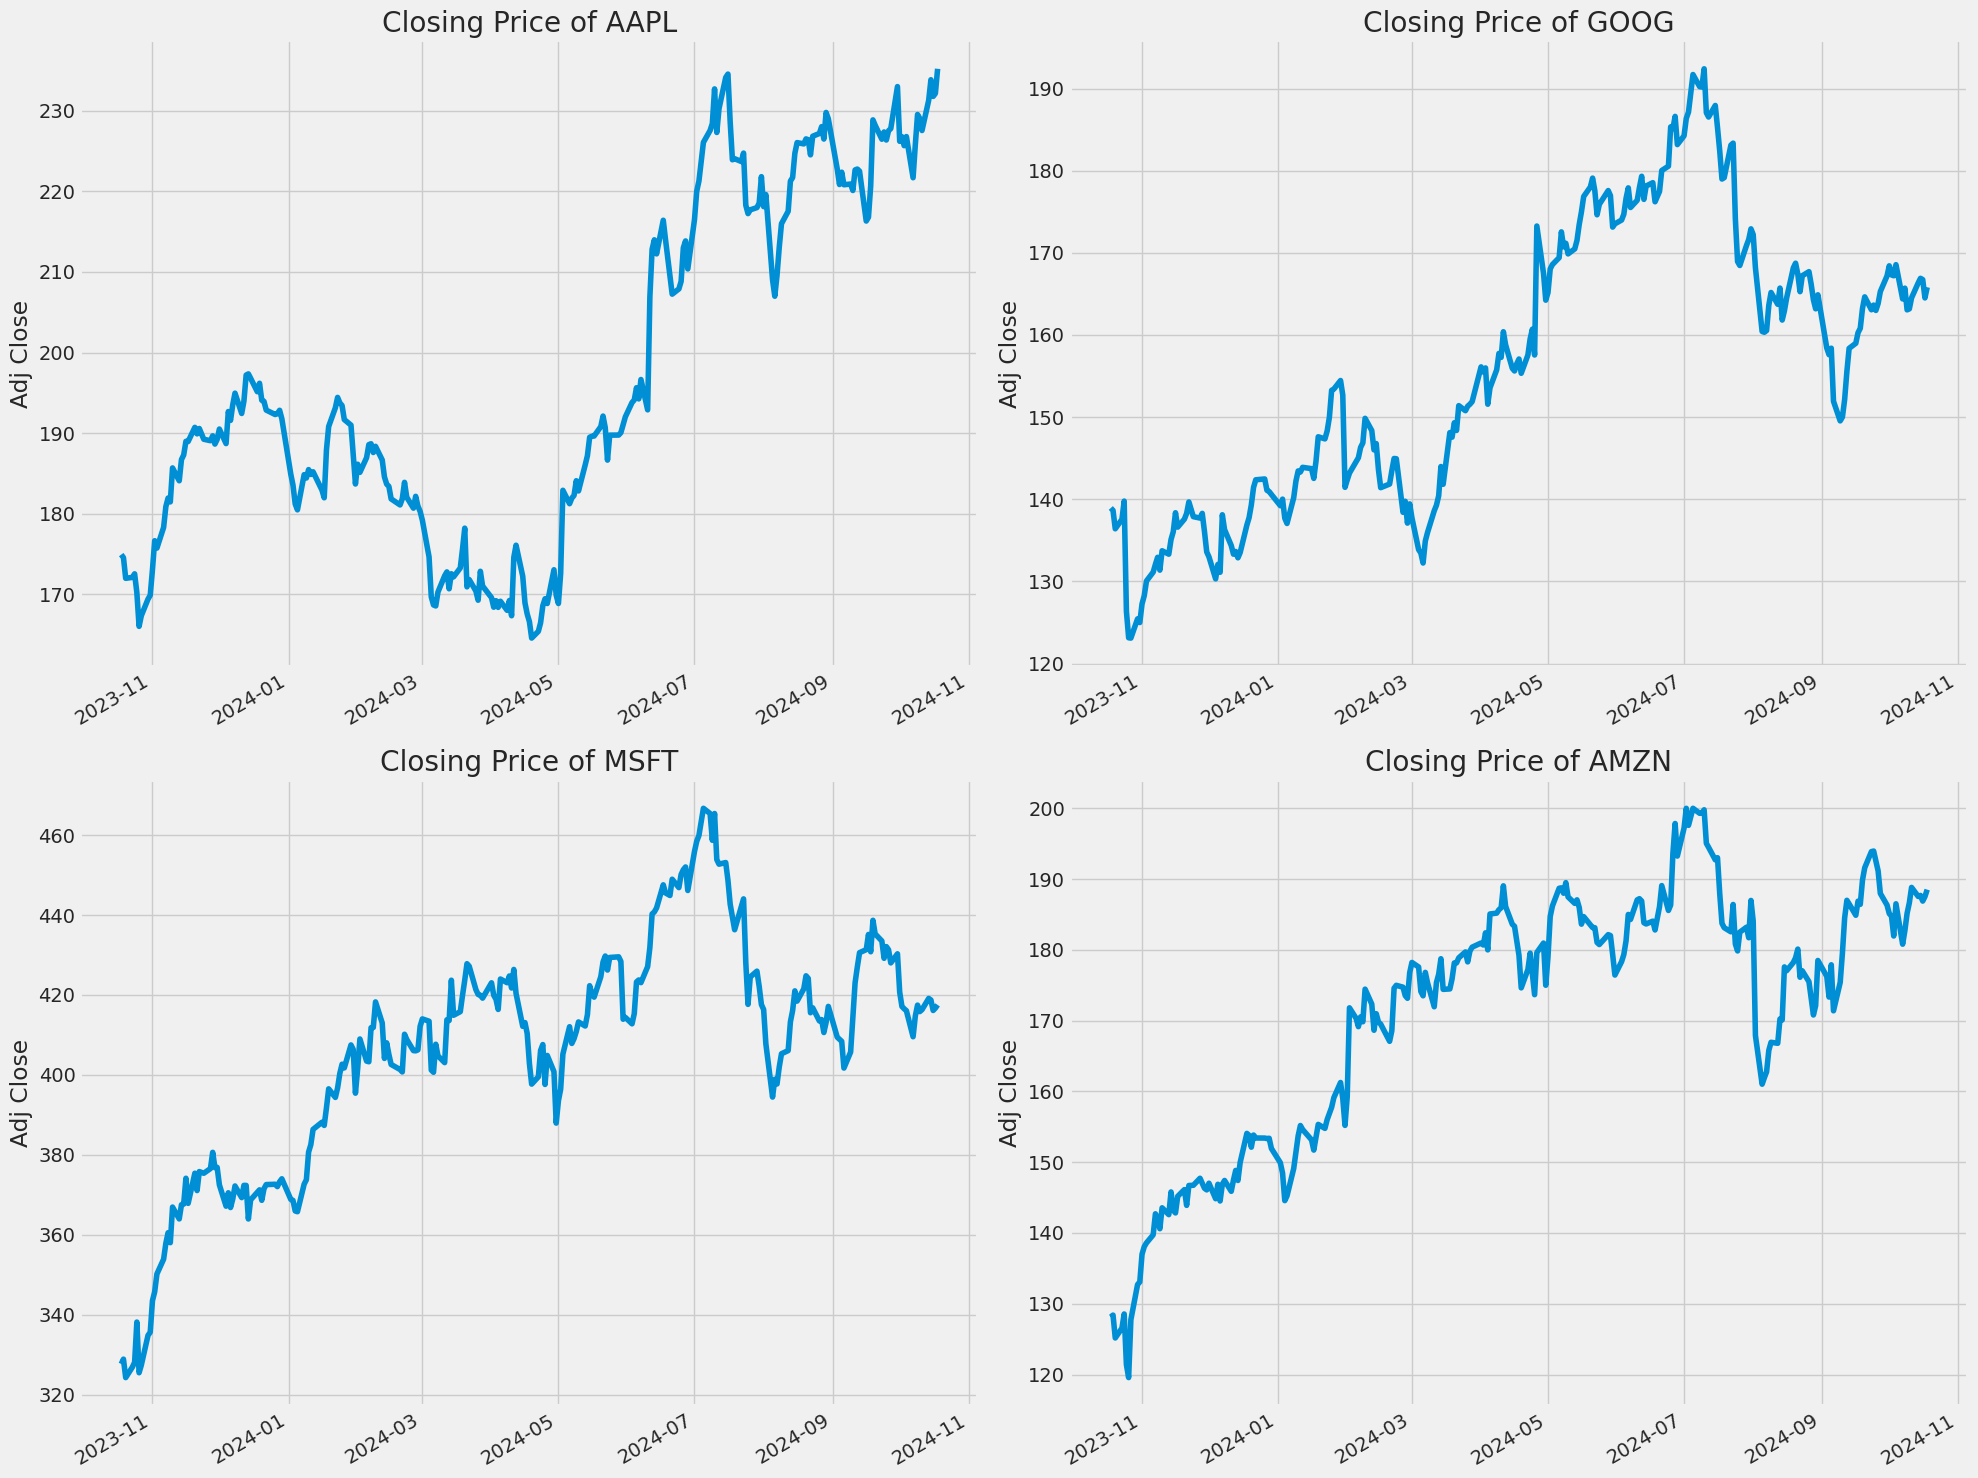

In [20]:
# adjusted closing price(Adj Close) takes dividends, stock splits, and new stock offerings into account
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


for i, company in enumerate(company_list):
    plt.subplot(2, 2, i+1)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i]}")
    
    
plt.tight_layout()

- #### Volume of Sales

Amount trading volume that are trading in market

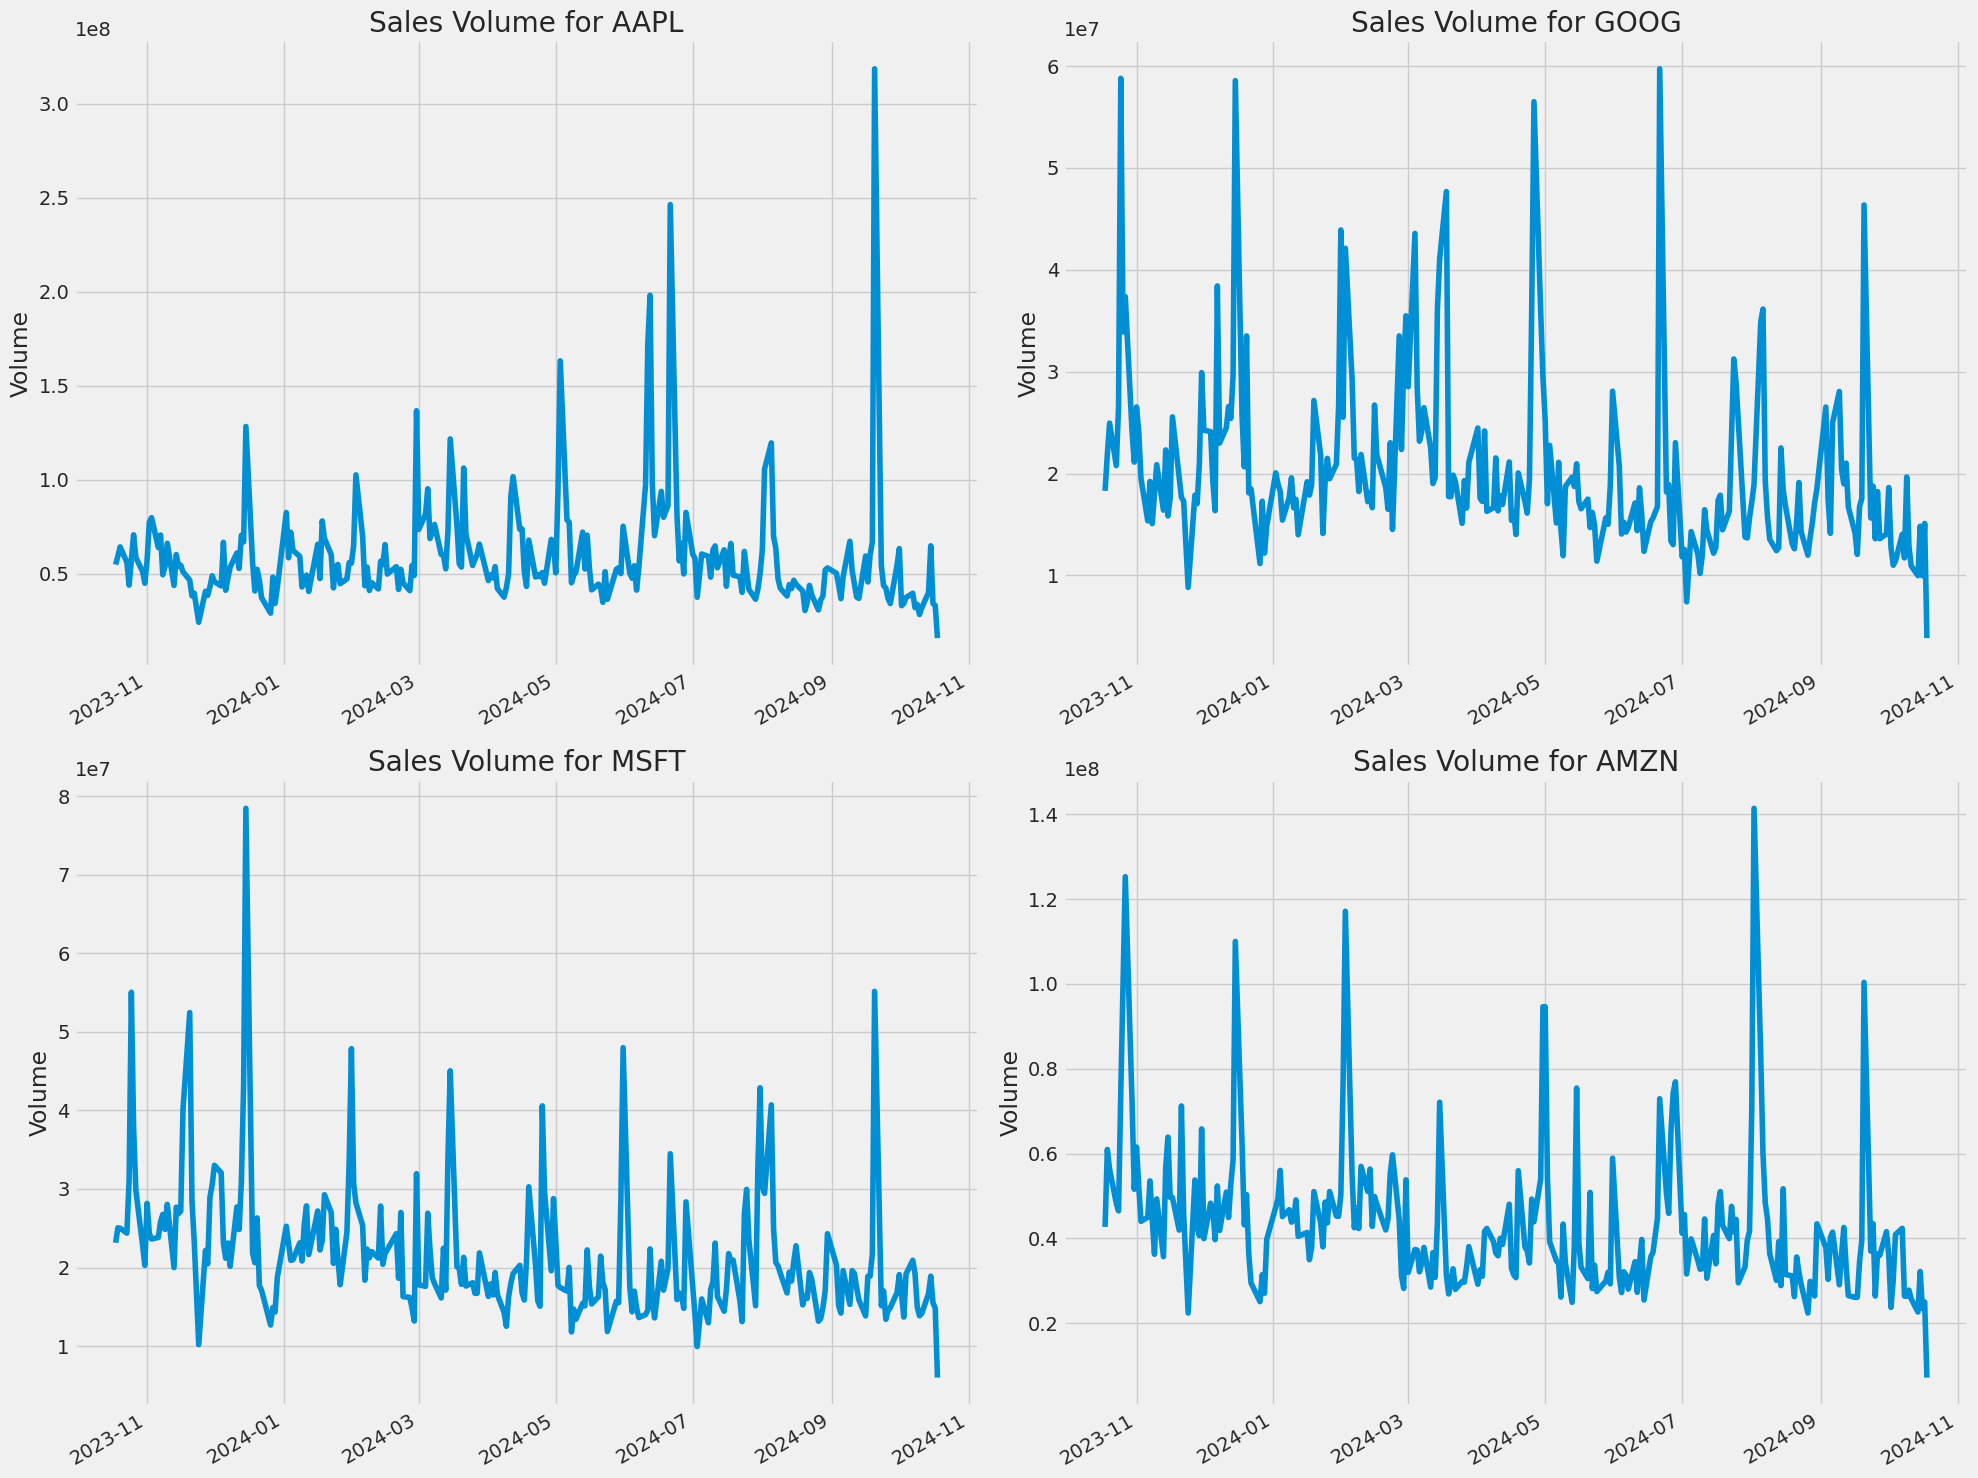

In [21]:
# adjusted closing price(Adj Close) takes dividends, stock splits, and new stock offerings into account
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i, company in enumerate(company_list):
    plt.subplot(2, 2, i+1)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i]}")
    
    
plt.tight_layout()

## Stock Market Analysis

- ### Moving Average
decision-making tool that tracks the movement of asset price charts

In [22]:
ma_day = [10, 20, 50] # Moving Average day for 10,20 and 50 days
stock_name = stock_data.keys() 

for ma in ma_day:
    for com_name in stock_name:
        column_name = f"MA for {ma} days"
        company = stock_data[com_name]
        company[column_name] = company['Adj Close'].rolling(ma).mean() # rolling window will specified number of past data points for each calculation

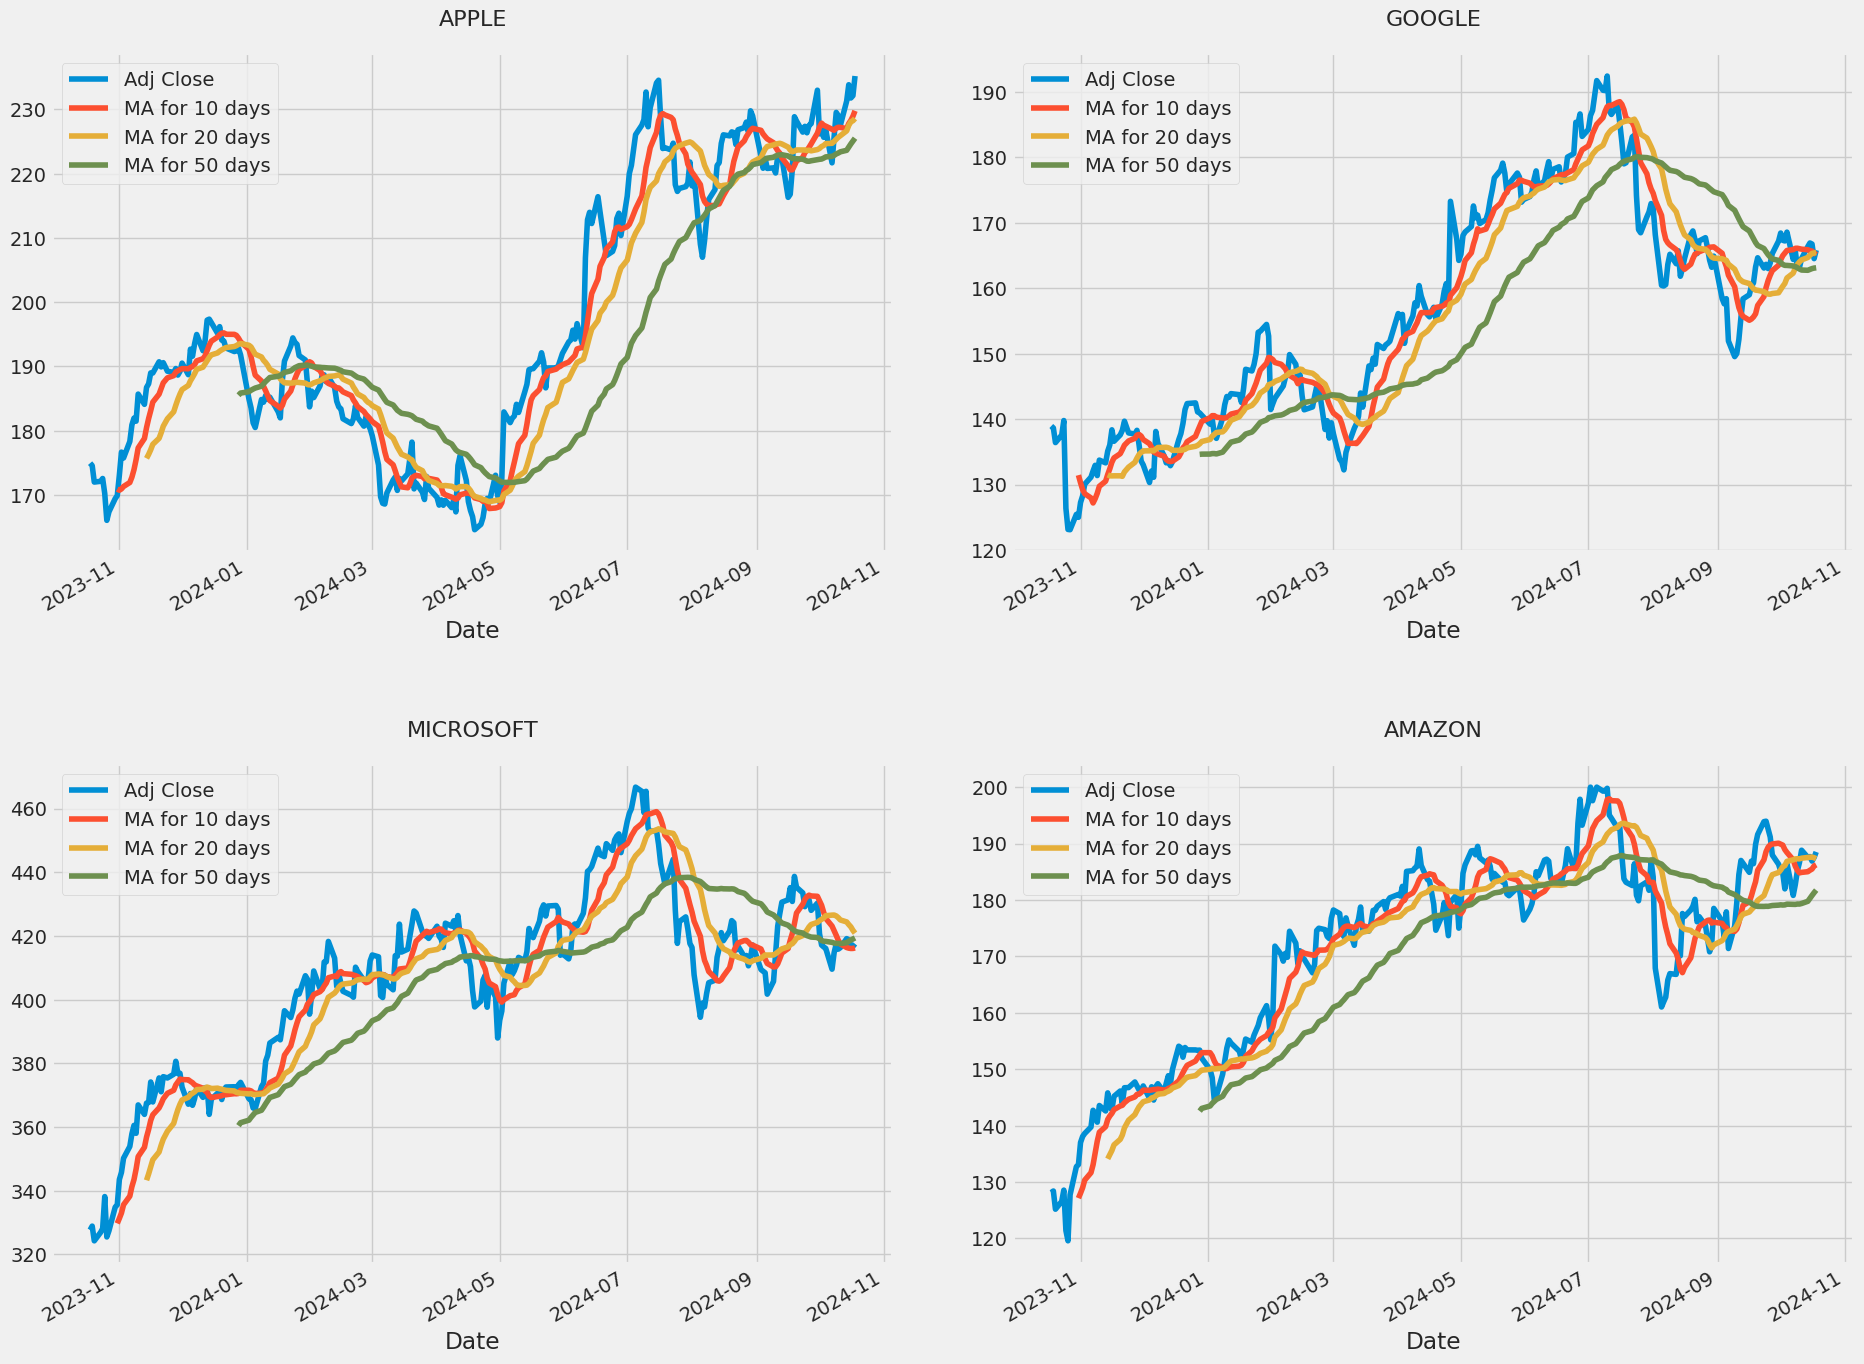

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))  # Increased figure size

# Plot data for each company
stock_data['AAPL'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE', fontsize=16, pad=20)  # Increased font size and padding

stock_data['GOOG'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE', fontsize=16, pad=20)

stock_data['MSFT'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT', fontsize=16, pad=20)

stock_data['AMZN'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON', fontsize=16, pad=20)

# Adjust layout
plt.tight_layout(pad=4.0)  # Increased padding

# Show plot
plt.show()

- ### Daily Return
    - represents the day-to-day percentage change in the stock's price
    - It's the percentage change in a stock's price from one trading day to the next.

In [24]:
# We'll use pct_change to find the percent change for each day
# It start calculate in second day
for company in stock_data.values():
    company['Daily Return'] = company['Adj Close'].pct_change()

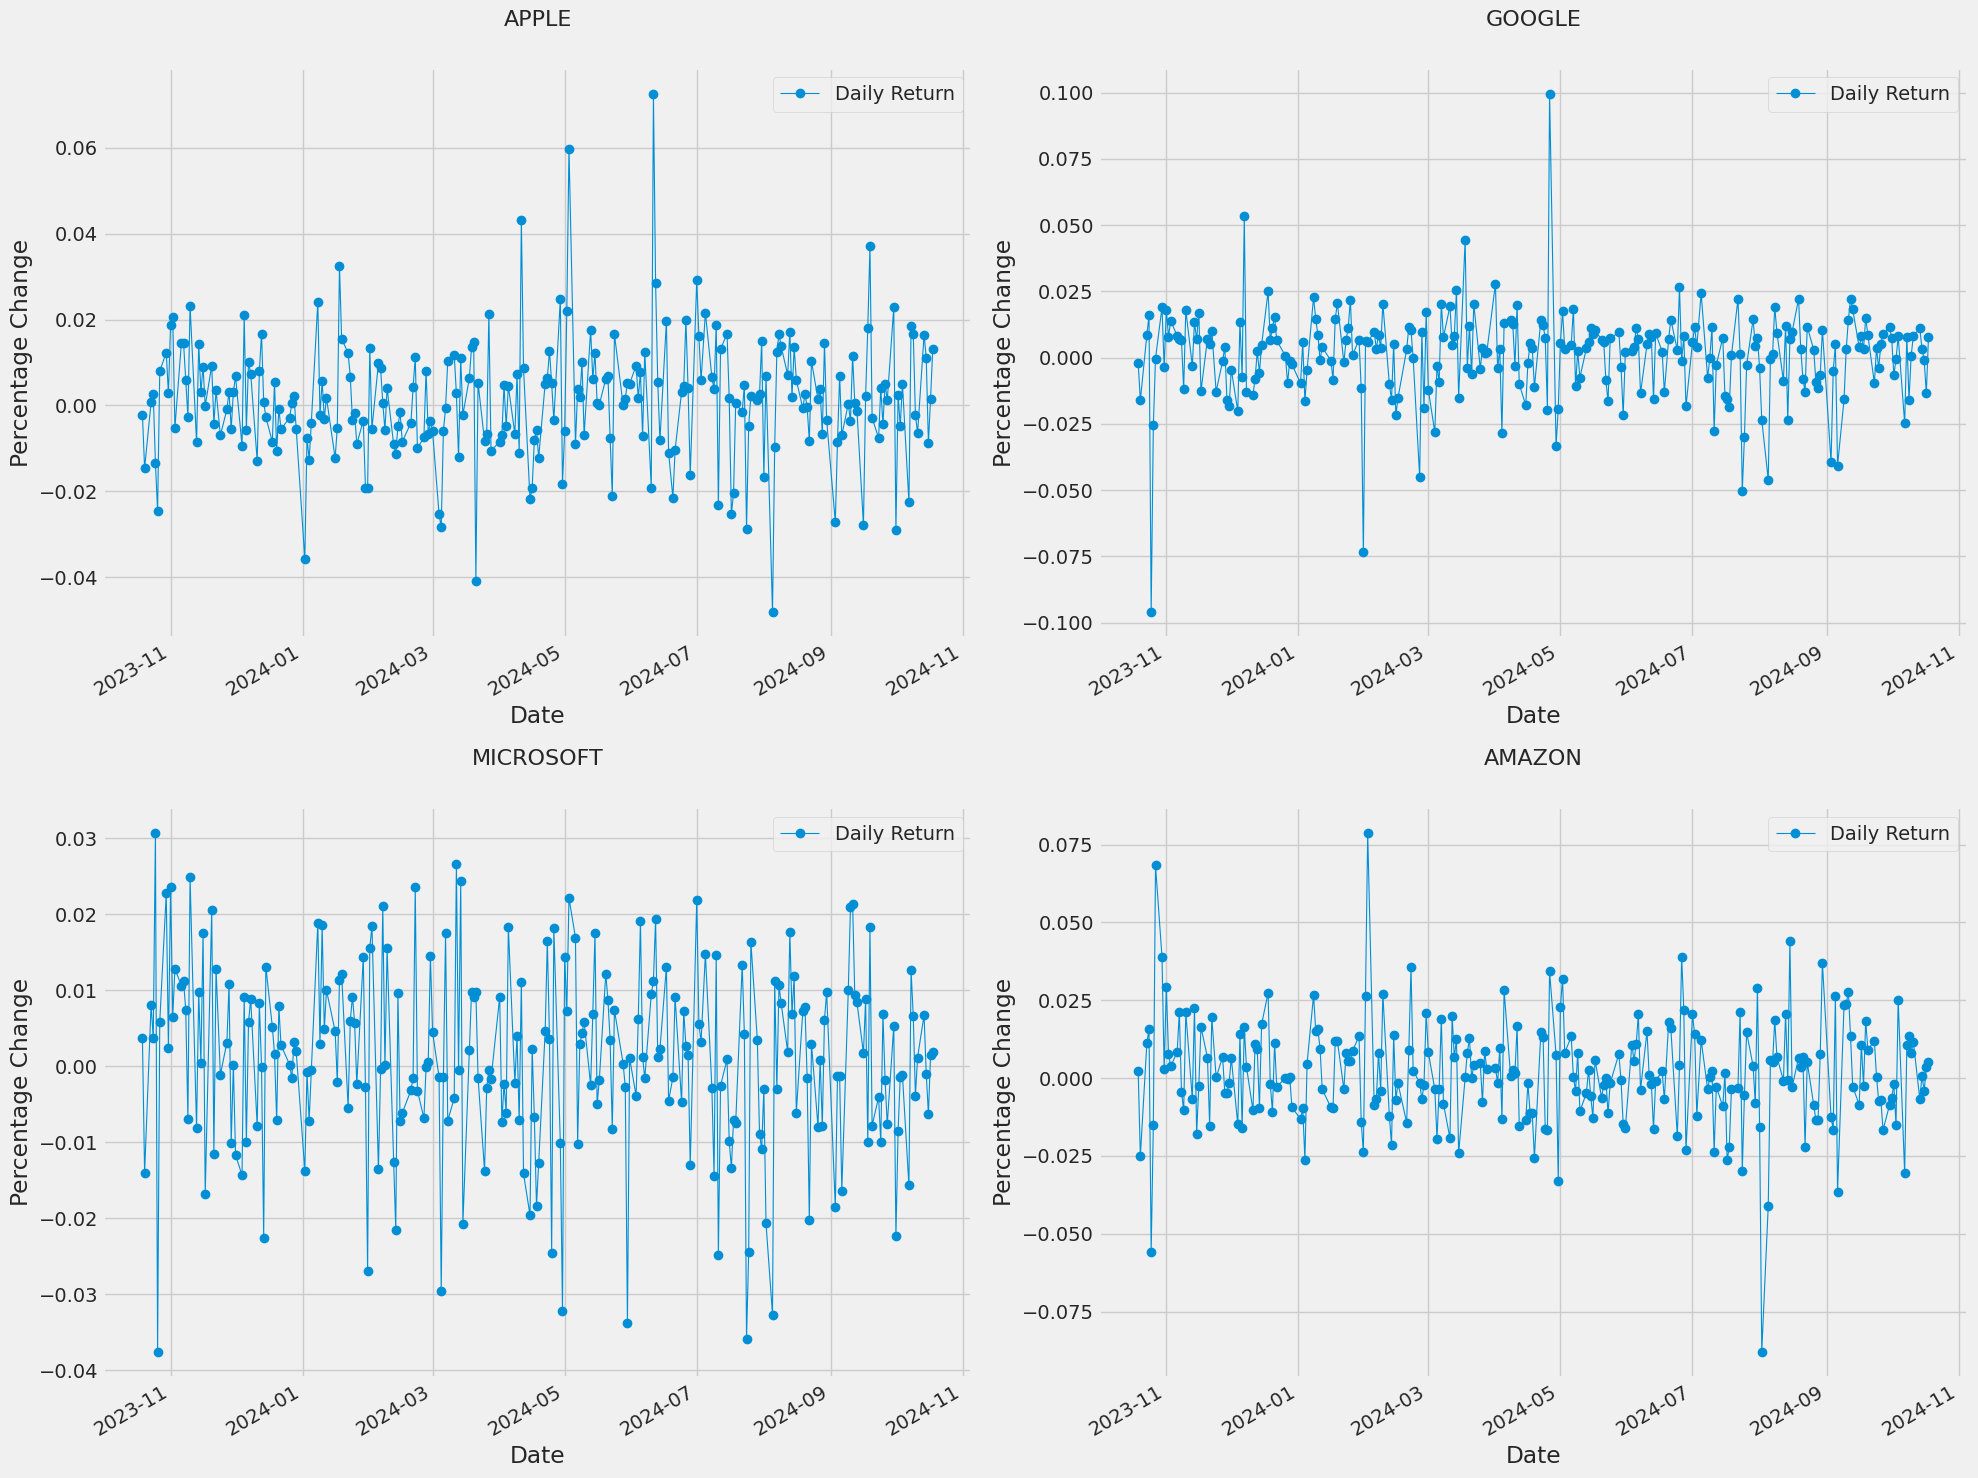

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

stock_data['AAPL'][['Daily Return']].plot(ax=axes[0,0], legend=True, linestyle='-', linewidth=0.8, marker='o')
axes[0,0].set_ylabel('Percentage Change')
axes[0,0].set_title('APPLE', fontsize=16, pad=30)

stock_data['GOOG'][['Daily Return']].plot(ax=axes[0,1], legend=True, linestyle='-', linewidth=0.8, marker='o')
axes[0,1].set_ylabel('Percentage Change')
axes[0,1].set_title('GOOGLE', fontsize=16, pad=30)

stock_data['MSFT'][['Daily Return']].plot(ax=axes[1,0], legend=True, linestyle='-', linewidth=0.8, marker='o')
axes[1,0].set_ylabel('Percentage Change')
axes[1,0].set_title('MICROSOFT', fontsize=16, pad=30)

stock_data['AMZN'][['Daily Return']].plot(ax=axes[1,1], legend=True, linestyle='-', linewidth=0.8, marker='o')
axes[1,1].set_ylabel('Percentage Change')
axes[1,1].set_title('AMAZON', fontsize=16, pad=30)

plt.tight_layout()

## Predicting the closing price stock price of APPLE inc

In [26]:
# 10 year stock data
end = datetime.now() # current date
start = datetime(end.year - 10, end.month, end.day)

# Get the stock quote
df = yf.download('AAPL', start=start, end=end)

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-20,24.580000,24.990000,24.555000,24.940001,22.144403,310069200
2014-10-21,25.754999,25.754999,25.317499,25.617500,22.745960,378495600
2014-10-22,25.709999,26.027500,25.650000,25.747499,22.861391,273052400
2014-10-23,26.020000,26.262501,25.907499,26.207500,23.269831,284298800
2014-10-24,26.295000,26.372499,26.132500,26.305000,23.356401,188215600
...,...,...,...,...,...,...
2024-10-14,228.699997,231.729996,228.600006,231.300003,231.300003,39882100
2024-10-15,233.610001,237.490005,232.369995,233.850006,233.850006,64751400
2024-10-16,231.600006,232.119995,229.839996,231.779999,231.779999,34082200


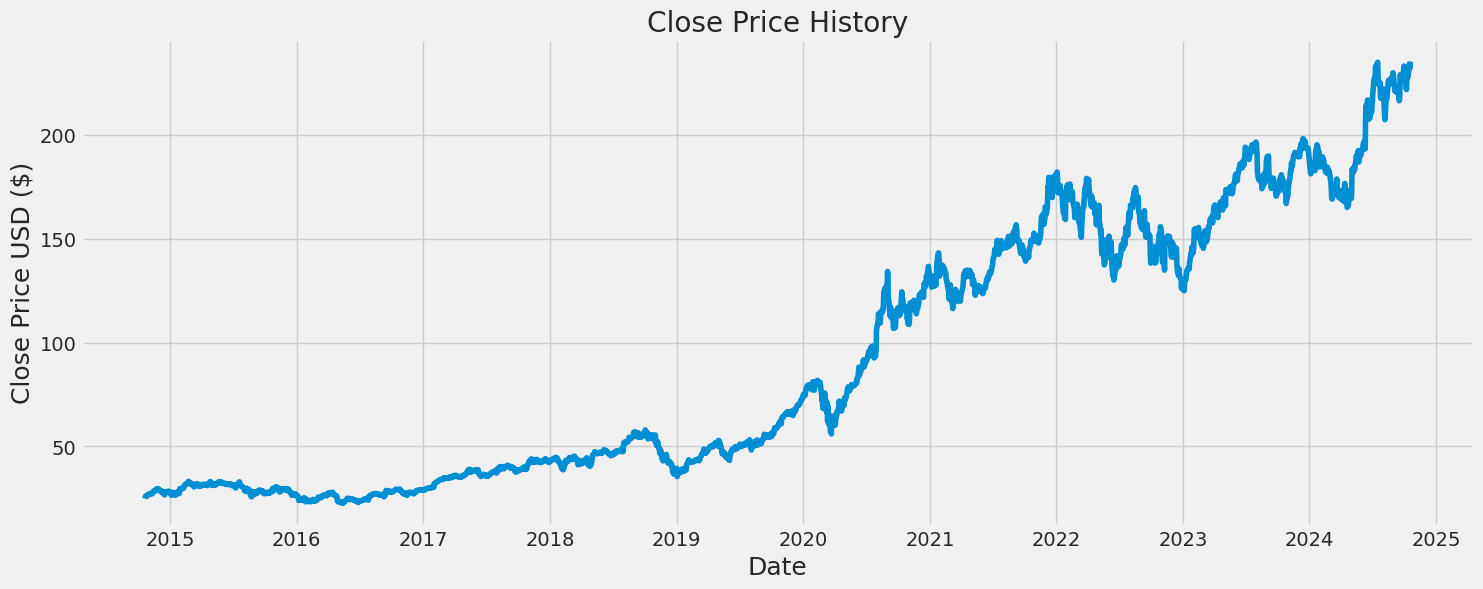

In [27]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [28]:
data = df.filter(['Close'])

In [29]:
data.head()

,Close
Date,
2014-10-20,24.940001
2014-10-21,25.617500
2014-10-22,25.747499
2014-10-23,26.207500
2014-10-24,26.305000


In [30]:
dataset = data.values.reshape(-1, 1)
dataset

array([[ 24.94000053],
       [ 25.61750031],
       [ 25.74749947],
       ...,
       [231.77999878],
       [232.1499939 ],
       [235.11010742]])

In [31]:
dataset.shape

(2517, 1)

In [32]:
# scales the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [33]:
print(scaled_data)
print(len(scaled_data))

[[0.01108105]
 [0.01426891]
 [0.0148806 ]
 ...
 [0.98433075]
 [0.9860717 ]
 [1.        ]]
2517


In [34]:
# Create Dataset
def create_dataset(data, seq_length):
    X = []
    y = []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # Sequence of 'seq_length' days
        y.append(data[i, 0])    # Target is the next day after the sequence
    
    return np.array(X), np.array(y)

In [35]:
sequence_length = 50
X, y = create_dataset(scaled_data, sequence_length)

In [36]:
train_data_len = int(0.8 * len(X))
X_train, X_test = X[:train_data_len], X[train_data_len:]
y_train, y_test = y[:train_data_len], y[train_data_len:]

Reshape input for LSTM

- LSTM Input Shape:
    - LSTM layers in Keras (and TensorFlow) expect input data in a specific 3D shape: (samples, time steps, features)
        - samples: the number of sequences (in our case, the number of 60-day windows)
        - time steps: the number of time steps in each sequence (in our case, 60)
        - features: the number of features at each time step (in our case, 1, as we're only using the closing price)

- Original Shape:
    - Before reshaping, X_train and X_test are 2D arrays with shape: (number of samples, sequence length)

In [37]:
# Reshape input for LSTM [samples, time steps, features] 
'''
    X_train.shape[0]: keeps the number of samples unchanged
    X_train.shape[1]: keeps the sequence length (60 in our case) unchanged
    1: adds a new dimension for the number of features
'''
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
X_train

array([[[0.01108105],
        [0.01426891],
        [0.0148806 ],
        ...,
        [0.02782024],
        [0.02772614],
        [0.02609104]],

       [[0.01426891],
        [0.0148806 ],
        [0.01704505],
        ...,
        [0.02772614],
        [0.02609104],
        [0.02357369]],

       [[0.0148806 ],
        [0.01704505],
        [0.01750382],
        ...,
        [0.02609104],
        [0.02357369],
        [0.02233854]],

       ...,

       [[0.71504494],
        [0.71316277],
        [0.70078781],
        ...,
        [0.59694122],
        [0.61053961],
        [0.59647073]],

       [[0.71316277],
        [0.70078781],
        [0.68220178],
        ...,
        [0.61053961],
        [0.59647073],
        [0.57506148]],

       [[0.70078781],
        [0.68220178],
        [0.68060192],
        ...,
        [0.59647073],
        [0.57506148],
        [0.62653777]]])

In [39]:
# build NN model
model = tf.keras.Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0569 - val_loss: 0.0112
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8156e-04 - val_loss: 0.0026
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6466e-04 - val_loss: 0.0015


In [41]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Test Loss: 0.0014847501879557967


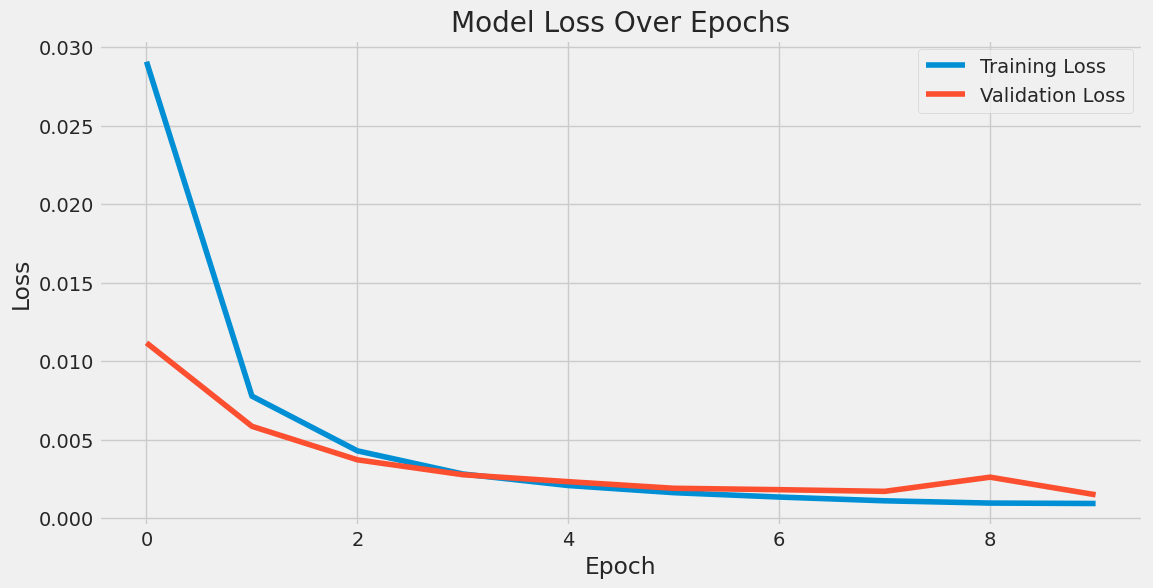

In [42]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have already trained your model and have the history object
plot_loss(history)

In [43]:
# Create testing data for prediction
test_data = scaled_data[train_data_len - sequence_length: , :]

x_test = []
y_test = dataset[train_data_len:, :]

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [44]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [45]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6.655605763911839

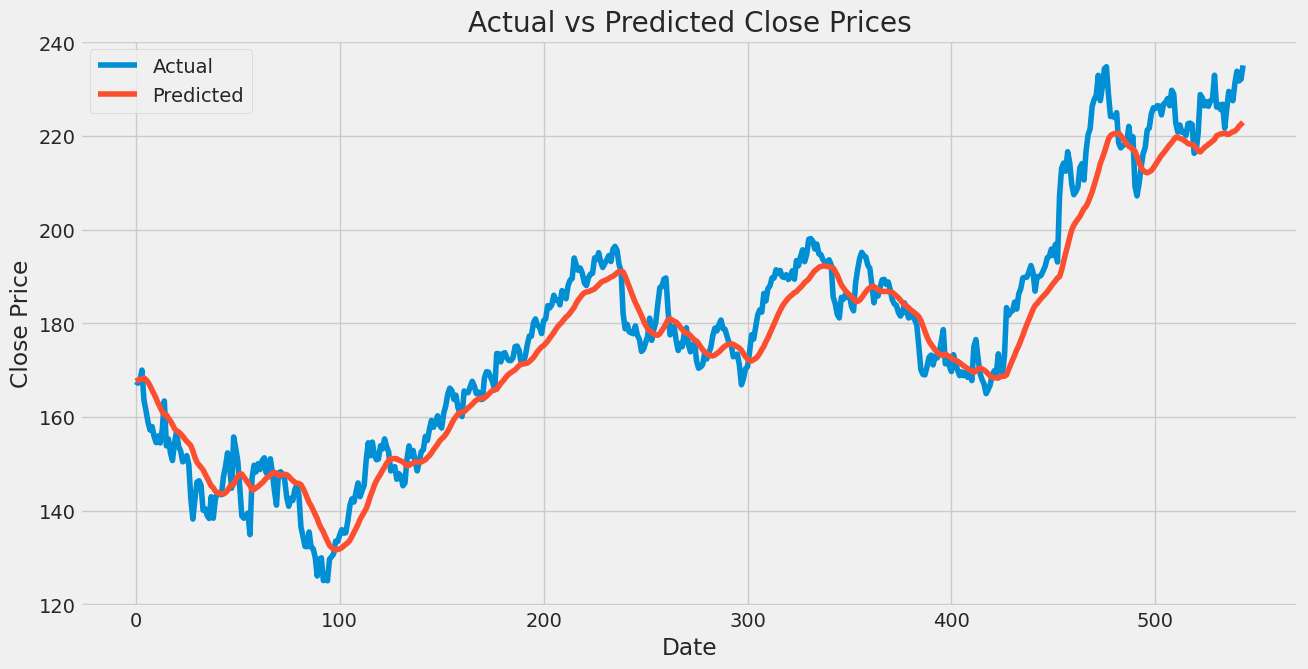

In [46]:
plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [47]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

/tmp/ipykernel_23/2341986142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [48]:
valid

,Close,Predictions
Date,,
2022-08-22,167.570007,167.661667
2022-08-23,167.229996,167.894974
2022-08-24,167.529999,168.012451
2022-08-25,170.029999,168.088257
2022-08-26,163.619995,168.318726
...,...,...
2024-10-14,231.300003,221.073944
2024-10-15,233.850006,221.487457
2024-10-16,231.779999,222.096375


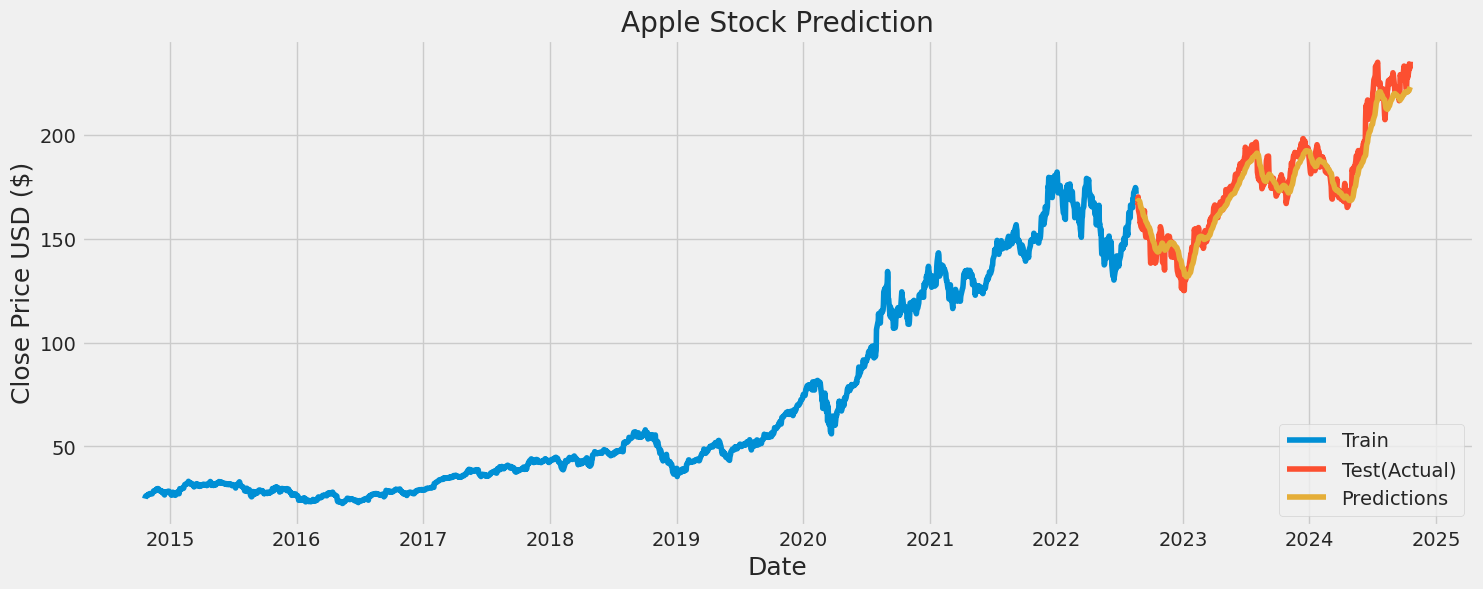

In [49]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Apple Stock Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test(Actual)', 'Predictions'], loc='lower right')
plt.show()